## Dataset

**Data fields:**
    
- **Patient_ID** - The unique identifier of the patient
- **Family_Case_ID** - The family identification
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity
- **Name** - The name of the patient
- **Birthday_year** - The year of birthday of the patient
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected
- **Partner_Children_Infected** - The number of partner and/or children infected
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family
- **Medical_Tent** - The medical tent where the patient is / was lodged
- **City** - The original city of the patient
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

## Libraries

In [116]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV,LassoCV,RidgeCV, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.svm import SVC, LinearSVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb
import math
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn import metrics
import optuna
import functools

## Functions

In [2]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    for train_index, val_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)

In [3]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1
    return df

In [4]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sb.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [5]:
def plt_box(data):
    n_col = 2
    n_row = 2
    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 10))
    for var, subplot in zip(data[numerical], ax.flatten()):
        sb.boxplot(data[var], ax=subplot)

In [6]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

 ## Data exploration

### Full dataset exploration

preprocess as types 
year as integer 
patient_id and Family case as text

In [7]:
Pandemic = pd.read_csv("train.csv")
Pandemic.describe(include='all')

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


In [8]:
# Check missing values
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


**Initial considerations:**

We have 900 patients records
* one patient name repeats once but looking at the patients info we conclude these are two different people with same names
* Families can be tracked by Family_case_ID
* Birthday Year not available for everyone - fill in with KNNFiller? Also easier to work with age so will create a column "Age"(as of January 1st, 2020 when epidemic started)
* City has two missing values - fill in with KNNImputer?
* Medical tent can be unknown? (are there patients without tent or its data collection error?) so we cannot realy extrapolate these values and there are too many patients without Tent (almost 80%)
* Medical tent has many categories (8). This can indicate an issue with distribution. Can convert to binary (Tent - Yes-No).
* target value (deceased or not) is evenly distributed



In [9]:
# Exploration of categorical variables: cross table of Tents and city and severity of infection
table1 = pd.crosstab(index=Pandemic['City'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
City,,,
Albuquerque,85,17,67
Santa Fe,127,165,357
Taos,2,4,74


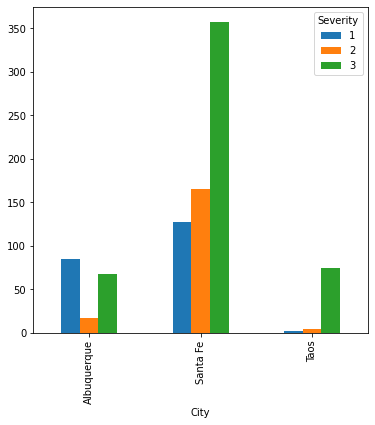

In [10]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=False)

In [11]:
table1 = pd.crosstab(index=Pandemic['Medical_Tent'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
Medical_Tent,,,
A,15,0,0
B,46,0,0
C,56,0,1
D,27,4,0
E,24,4,3
F,0,8,5
G,0,0,4
T,1,0,0


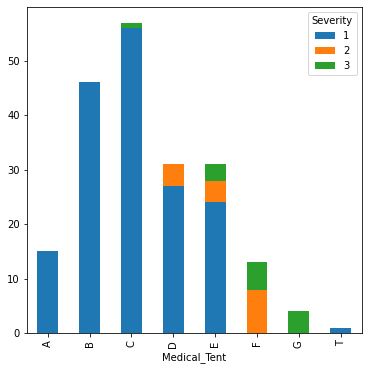

In [12]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

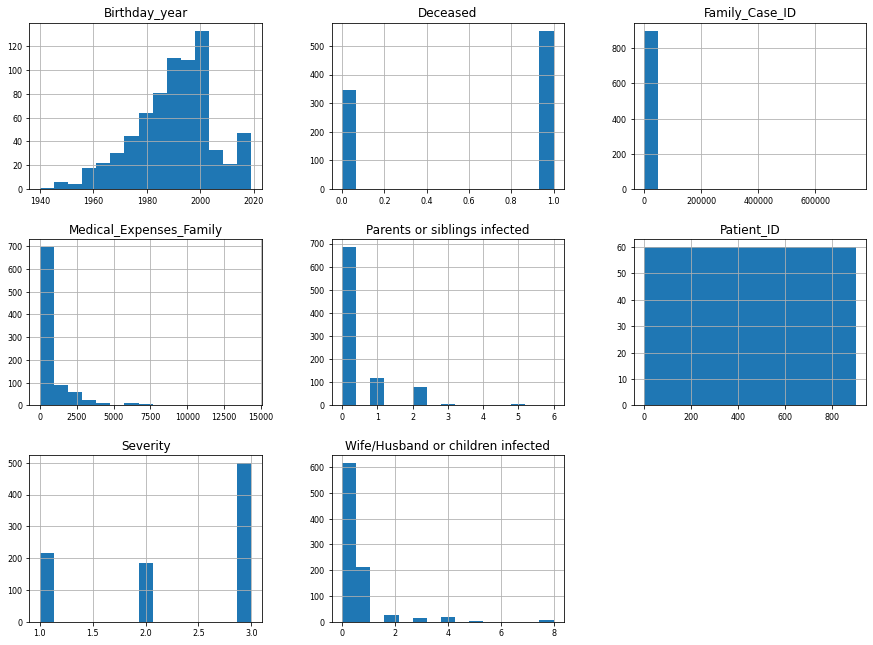

In [13]:
# Do histograms on all numeric variables
numerical=Pandemic.select_dtypes(include=[np.number]).columns.tolist()
Pandemic[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

Age has somewhat normal distribution, but Medical expenses need to be transformed. Also Infected family needs to be looked at.

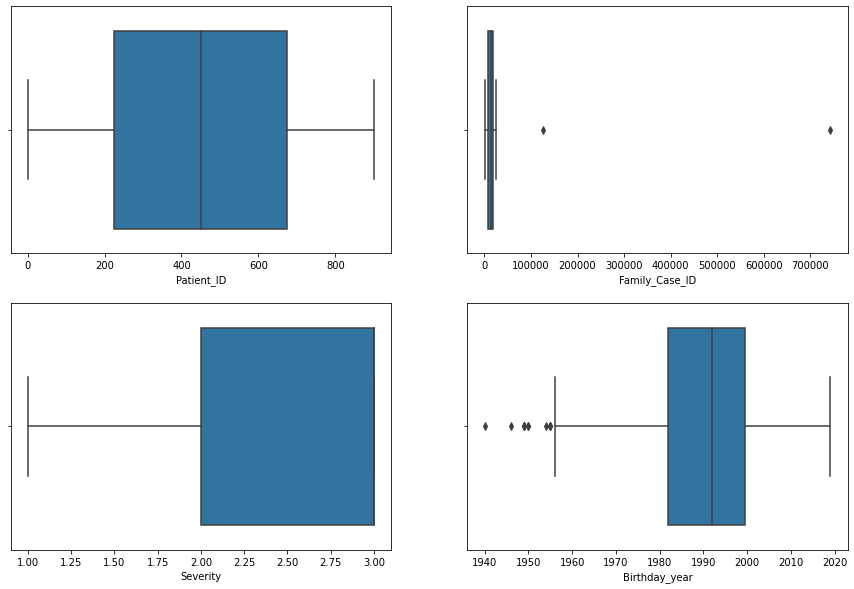

In [14]:
# Boxplots on all numeric variables
plt_box(Pandemic[numerical])

### Exploration of variables in relation to target

In [15]:
#average metrics for Deceased and Survivors to get initial insights
Pandemic.groupby('Deceased').mean()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,,
0,449.423631,13619.536023,1.962536,1991.698305,0.463977,0.475504,1340.755043
1,451.175407,14736.466546,2.533454,1989.280374,0.327306,0.549729,616.504521


In [16]:
#Exploring categorical features
piv1=pd.pivot_table(Pandemic, values='Patient_ID', index=['City'], columns=['Deceased'],aggfunc='count')
piv2=pd.pivot_table(Pandemic, values='Patient_ID', index=['Severity'], columns=['Deceased'],aggfunc='count')
piv3=pd.pivot_table(Pandemic, values='Patient_ID', index=['Medical_Tent'], columns=['Deceased'],aggfunc='count')

display_side_by_side(piv1,piv2,piv3)


Deceased,0,1
City,,
Albuquerque,94,75
Santa Fe,221,428
Taos,30,50
Deceased,0,1
Severity,,
1,136,80
2,88,98
3,123,375
Deceased,0,1


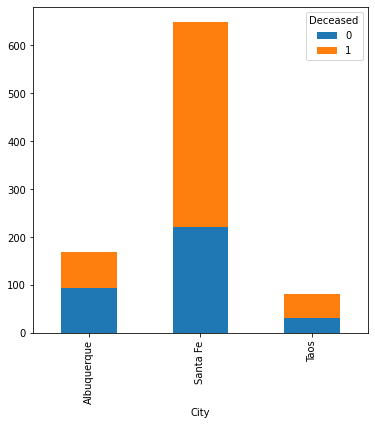

In [17]:
piv1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

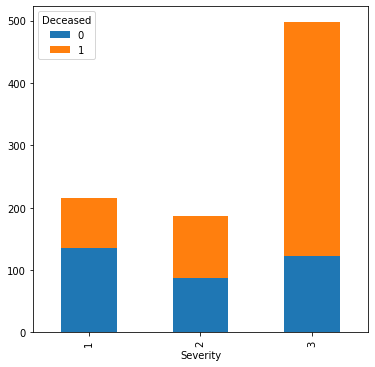

In [18]:
piv2.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

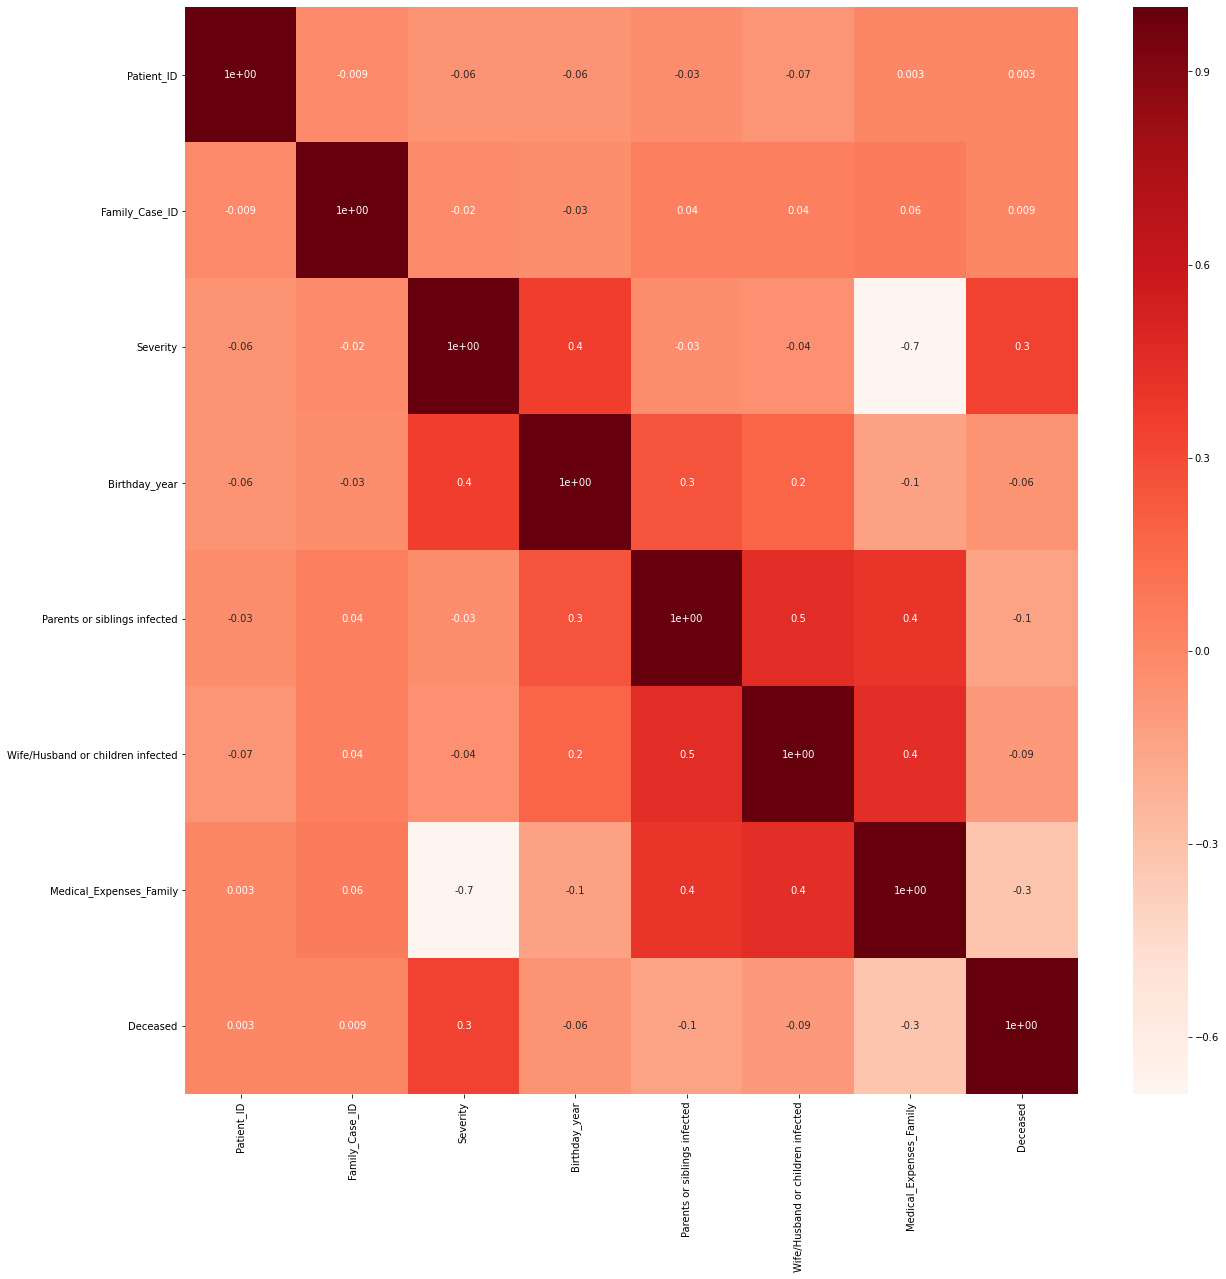

In [19]:
corr_df = Pandemic.corr('spearman')
cor_heatmap(corr_df)

In [20]:
abs(corr_df['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.334289
Medical_Expenses_Family              0.319579
Parents or siblings infected         0.140860
Wife/Husband or children infected    0.093854
Birthday_year                        0.058452
Family_Case_ID                       0.009041
Patient_ID                           0.003282
Name: Deceased, dtype: float64

**Some conclusions relating to target variable and input features**

* Family infected - younger patients die less, lower average in "Parents or siblings infected" can be explained by this. Also the two variables for infected in family seem to relay similar info so potentially can be merged into one feature "Family members infected" which reflects sum of the two columns
* Discard of "Medical_Tent" as almost 80% records do not have it or replace nulls with 9th category "No Tent"
* Create age variable
* Santa Fe has worst situation for severity of disease and number of infected, Albuquerque is next in number of infected but still has more people with lighter form of illness than the severe
* Survivors have spent more on medical expenses
* Severity, Medical expenses and Birthday Year are highly correlated.
* Partners/kids and parents/siblings are correlated

 **Severity, Medical expenses and infected family are most important features for the outcome of the illness**


## Pre-Processing

In [21]:
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


In [22]:
Pandemic

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0
5,6,17598,2,Master Terrell Bob,NaN,0,0,0,NaN,Santa Fe,1
6,7,7563,3,Mr. Kristopher Francis,1984.0,0,1,435,NaN,Santa Fe,1
7,8,9520,2,Mr. Lorenzo Bennie,1989.0,0,0,364,NaN,Santa Fe,0
8,9,6314,3,Mr. Rickey Dennis,2000.0,1,1,441,NaN,Albuquerque,0
9,10,14392,3,Miss Elena Cathy,NaN,1,1,626,F,Albuquerque,0


In [23]:
#dropping missing city
Pandemic.dropna(subset=['City'],axis=0,inplace=True)

In [24]:
#filling the missing Medical tent with "None"
Pandemic['Medical_Tent'].fillna('None',inplace=True)

In [25]:
Pandemic

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,None,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,None,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,None,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,None,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,None,Santa Fe,0
5,6,17598,2,Master Terrell Bob,NaN,0,0,0,None,Santa Fe,1
6,7,7563,3,Mr. Kristopher Francis,1984.0,0,1,435,None,Santa Fe,1
7,8,9520,2,Mr. Lorenzo Bennie,1989.0,0,0,364,None,Santa Fe,0
8,9,6314,3,Mr. Rickey Dennis,2000.0,1,1,441,None,Albuquerque,0
9,10,14392,3,Miss Elena Cathy,NaN,1,1,626,F,Albuquerque,0


#### KNN Imputer for Birthday Year

In [26]:
imputer = KNNImputer(n_neighbors=3)


In [27]:
imputer.fit(Pandemic[['Birthday_year']])

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform')

In [28]:
Birthday_imputed = imputer.transform(Pandemic[['Birthday_year']])

In [29]:
Birthday_imputed = pd.DataFrame(Birthday_imputed, columns = Pandemic[['Birthday_year']].columns, index = Pandemic.index)

In [30]:
Birthday_imputed = Birthday_imputed.astype(int)
Birthday_imputed

,Birthday_year
0,1990
1,1966
2,1982
3,1997
4,1994
5,1990
6,1984
7,1989
8,2000
9,1990


In [31]:
Pandemic = Pandemic.assign(Birthday_year=Birthday_imputed['Birthday_year'])
Pandemic

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,1990,0,0,225,None,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966,0,1,1663,None,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982,0,0,221,None,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997,0,0,220,None,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994,0,0,222,None,Santa Fe,0
5,6,17598,2,Master Terrell Bob,1990,0,0,0,None,Santa Fe,1
6,7,7563,3,Mr. Kristopher Francis,1984,0,1,435,None,Santa Fe,1
7,8,9520,2,Mr. Lorenzo Bennie,1989,0,0,364,None,Santa Fe,0
8,9,6314,3,Mr. Rickey Dennis,2000,1,1,441,None,Albuquerque,0
9,10,14392,3,Miss Elena Cathy,1990,1,1,626,F,Albuquerque,0


Check missing values in dataset

In [32]:
print(Pandemic.isnull().sum())

#create new variables age and Family infected 
Pandemic['Age']=2020-Pandemic['Birthday_year']
Pandemic.drop(['Birthday_year'],axis=1,inplace=True)

#create new variable Family_infected
#Pandemic['Family_infected']=Pandemic['Parents or siblings infected']+Pandemic['Wife/Husband or children infected']
#Pandemic.drop(['Parents or siblings infected','Wife/Husband or children infected'],axis=1,inplace=True)


Patient_ID                           0
Family_Case_ID                       0
Severity                             0
Name                                 0
Birthday_year                        0
Parents or siblings infected         0
Wife/Husband or children infected    0
Medical_Expenses_Family              0
Medical_Tent                         0
City                                 0
Deceased                             0
dtype: int64


In [37]:
#drop name column
Pandemic.drop(['Name',"Patient_ID","Family_Case_ID"],axis=1,inplace=True)

#### Encoding categorical

In [38]:
# Encode categorical variables to dummy variables
import category_encoders as ce
encode = ['City', 'Medical_Tent']
ce_one_hot = ce.OneHotEncoder(cols = encode, use_cat_names=True)
encoded = ce_one_hot.fit_transform(Pandemic[encode])

complete = pd.concat([Pandemic, encoded], axis=1)
complete.drop(encode,axis=1,inplace=True)

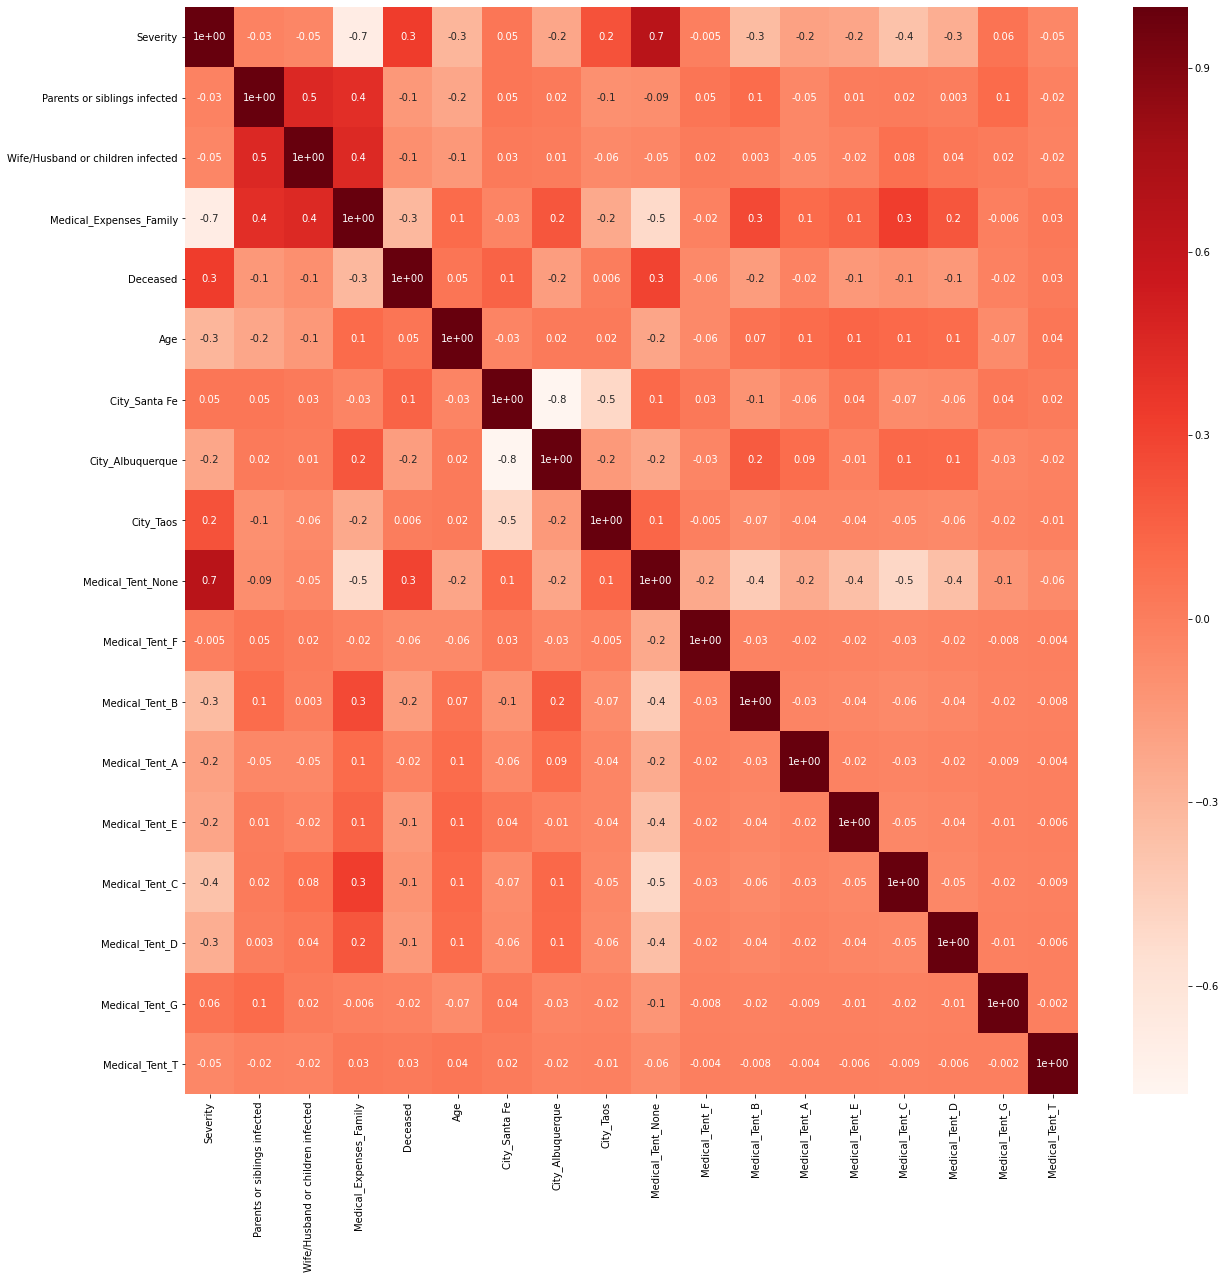

In [39]:
cor_heatmap(complete.corr('spearman'))

In [40]:
# drop high correlated variables where it makes sense
complete.drop('City_Albuquerque', axis=1, inplace=True)

In [41]:
abs(complete.corr()['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.330357
Medical_Tent_None                    0.297630
Medical_Expenses_Family              0.252494
Medical_Tent_B                       0.160105
City_Santa Fe                        0.144925
Medical_Tent_D                       0.139076
Medical_Tent_E                       0.139076
Medical_Tent_C                       0.113632
Parents or siblings infected         0.084364
Age                                  0.079661
Medical_Tent_F                       0.057609
Wife/Husband or children infected    0.031639
Medical_Tent_T                       0.026372
Medical_Tent_A                       0.022101
Medical_Tent_G                       0.015927
City_Taos                            0.005907
Name: Deceased, dtype: float64

In [42]:
#Split into data and target: X contains independent variables (before scaling) and y contains target
X = complete.drop(['Deceased'], axis=1)
y = complete['Deceased']

## Feature engineering

In [43]:
X["Medical_Expenses_Family_log"] = X.Medical_Expenses_Family.apply(lambda x: np.log(x+1))

#### Bin Age

In [44]:
X['Age_label'] = pd.cut(x = X['Age'], bins = [0, 17, 29, 45, 59, 80, 110], labels = [0, 1, 2, 3, 4, 5])
#X['Age_label'] = pd.cut(x = X['Age'], bins = [0, 17, 29, 45, 59, 80, 110], labels = [0, 1, 2, 3, 4, 5])

In [45]:
X['Age_label'] = X['Age_label'].astype('int')
#X['Age_label'] = X['Age_label'].astype('int')

In [46]:
X_temp = X.copy()

# Feature selection

In [47]:
scaler = StandardScaler().fit(X_temp)
X = pd.DataFrame(scaler.transform(X_temp),columns=X_temp.columns)

### RFE

In [48]:
model = LogisticRegression()
rfe = RFE(estimator = model)
X_rfe = rfe.fit_transform(X = X_temp, y = y)
model.fit(X=X_rfe, y = y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
rfe.ranking_

array([ 1,  6,  5, 10,  9,  1,  3,  1,  1,  8,  1,  1,  1,  2,  7,  1,  4,
        1])

In [50]:
selected_features = pd.Series(rfe.support_, index = X_temp.columns)
rfe_features = selected_features.index.tolist()
selected_features

Severity                              True
Parents or siblings infected         False
Wife/Husband or children infected    False
Medical_Expenses_Family              False
Age                                  False
City_Santa Fe                         True
City_Taos                            False
Medical_Tent_None                     True
Medical_Tent_F                        True
Medical_Tent_B                       False
Medical_Tent_A                        True
Medical_Tent_E                        True
Medical_Tent_C                        True
Medical_Tent_D                       False
Medical_Tent_G                       False
Medical_Tent_T                        True
Medical_Expenses_Family_log          False
Age_label                             True
dtype: bool

## Lasso Regression

In [51]:
reg = LassoCV()
reg.fit(X=X_temp, y=y)
print("Best alpha: %f" % reg.alpha_)

Best alpha: 0.170115


In [52]:
coef = pd.Series(reg.coef_, index=X_temp.columns)
lasso_features = coef[coef != 0].index.tolist()
coef.sort_values()

Medical_Expenses_Family             -0.000091
Severity                             0.000000
Medical_Tent_T                       0.000000
Medical_Tent_G                      -0.000000
Medical_Tent_D                      -0.000000
Medical_Tent_C                      -0.000000
Medical_Tent_E                      -0.000000
Medical_Tent_A                      -0.000000
Medical_Tent_B                      -0.000000
Medical_Tent_F                      -0.000000
Medical_Tent_None                    0.000000
City_Taos                           -0.000000
City_Santa Fe                        0.000000
Wife/Husband or children infected    0.000000
Parents or siblings infected        -0.000000
Medical_Expenses_Family_log         -0.000000
Age_label                            0.000000
Age                                  0.002810
dtype: float64

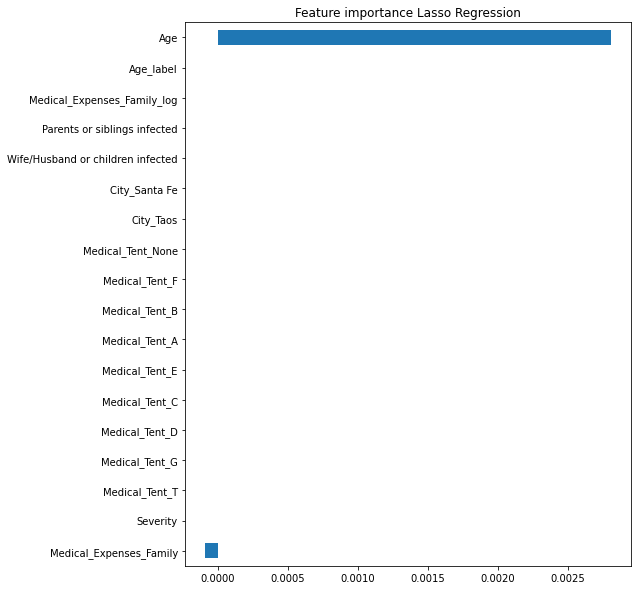

In [53]:
coef=coef.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Lasso Regression")
plt.show()

## Ridge Regression

In [54]:
ridge = RidgeCV()
ridge.fit(X=X_temp, y=y)
coef_ridge = pd.Series(ridge.coef_,index=X_temp.columns)
coef_ridge

Severity                             0.151285
Parents or siblings infected        -0.033749
Wife/Husband or children infected    0.049688
Medical_Expenses_Family              0.000002
Age                                  0.006595
City_Santa Fe                        0.089679
City_Taos                           -0.063234
Medical_Tent_None                    0.085502
Medical_Tent_F                      -0.070829
Medical_Tent_B                      -0.009629
Medical_Tent_A                       0.080346
Medical_Tent_E                      -0.124670
Medical_Tent_C                       0.079917
Medical_Tent_D                      -0.078029
Medical_Tent_G                      -0.014180
Medical_Tent_T                       0.051573
Medical_Expenses_Family_log         -0.061151
Age_label                            0.018763
dtype: float64

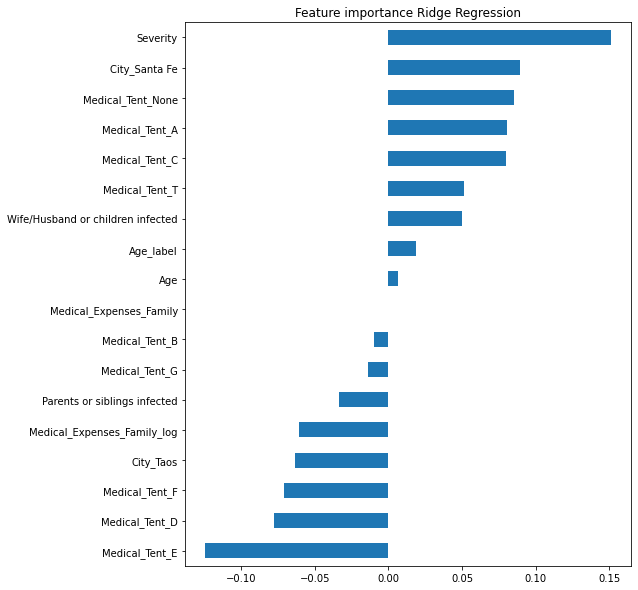

In [55]:
coef=coef_ridge.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Ridge Regression")
plt.show()

## Feature Importance Random Forest 

In [56]:
clf=RandomForestClassifier()
clf.fit(X_temp,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 576x720 with 0 Axes>

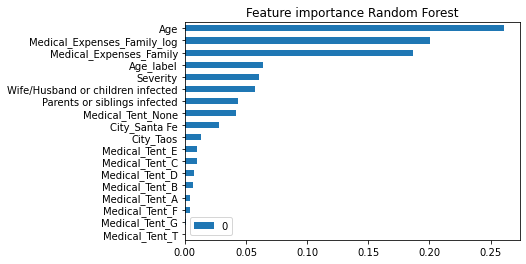

In [57]:
fi=pd.DataFrame(clf.feature_importances_, index=X_temp.columns).sort_values(by=0)
plt.figure(figsize=(8,10))
fi.plot(kind = "barh")
plt.title("Feature importance Random Forest")
plt.show()

### Drop features

In [94]:
### INSERT HERE THE SEVERAL DIFFERENT COMBINATIONS OF FEATURES TO DROP. KEEP ALL THE ITERATIONS.

todrop = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected', "Age_label", "Medical_Expenses_Family_log"]

todrop1 = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected', "Age_label", "Medical_Expenses_Family"]


In [95]:
#drop variables based on low correlations with target and high mutual correlations

X.drop(todrop1,axis=1,inplace=True)

In [96]:
X.columns

Index(['Severity', 'Parents or siblings infected', 'City_Santa Fe',
       'City_Taos', 'Medical_Tent_B', 'Medical_Tent_E', 'Medical_Tent_C',
       'Medical_Tent_D', 'Medical_Expenses_Family_log', 'Age_label'],
      dtype='object')

## Train and Validation Normalized

In [97]:
def split_scale(X,y,scale,size_test):
    """ This function scales the input dataset (X and y) and split both into train- and test sets
    Input: 
    X: Unscaled and unlabeled data
    y: The labels for X
    scale: choose between "StandardScaler", "MinMaxScaler" or "RobustScaler"
    size_test: size in percent of the test set 
    Output: X_train, X_test, y_train, y_test
    """
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=size_test,random_state=0)
    if scale == "RobustScaler":
        robust = RobustScaler().fit(X_train)
        X_train = robust.transform(X_train)
        X_test = robust.transform(X_test)
        return X_train, X_test,y_train,y_test
    elif scale == "MinMaxScaler":
        minmax = MinMaxScaler().fit(X_train)
        X_train = minmax.transform(X_train)
        X_test = minmax.transform(X_test)
        return X_train, X_test,y_train,y_test
    elif scale == "StandardScaler":
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test,y_train,y_test

In [98]:
X_train, X_val,y_train,y_val = split_scale(X,y,"StandardScaler",0.2)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

## Classifier

In [99]:
def model_compare(list_of_models):
    train_score=[]
    val_score=[]
    model_used=[]
    for i in list_of_models:
        model = i
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        val_score.append(model.score(X_val, y_val))
        model_used.append(str(i))
        y_pred = model.predict(X_val)
    df = pd.DataFrame([model_used, train_score, val_score], index=["model","train_score","val_score"]).T.sort_values(by="val_score", ascending=False)
    return df

In [100]:
model_list = [MLPClassifier(),LogisticRegression(),RandomForestClassifier(),
              KNeighborsClassifier(), GradientBoostingClassifier(),GaussianNB(),
              LogisticRegressionCV(),RidgeClassifier(),SVC(), LinearSVC(), XGBClassifier()]

model_compare(model_list)


,model,train_score,val_score
10,"XGBClassifier(base_score=0.5, booster=None, co...",0.887187,0.711111
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.810585,0.694444
0,"MLPClassifier(activation='relu', alpha=0.0001,...",0.774373,0.688889
7,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.71727,0.683333
9,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.71727,0.683333
1,"LogisticRegression(C=1.0, class_weight=None, d...",0.714485,0.672222
8,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.75766,0.672222
6,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.720056,0.666667
2,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.899721,0.655556
5,"GaussianNB(priors=None, var_smoothing=1e-09)",0.694986,0.633333


### 1. Multi-Layer Perceptron with default settings = Baseline

Default for MLPClassifier
parameter_space = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'solver': 'adam',
    'learning_rate_init': 0.001,
    'learning_rate': 'constant',
    'alpha': 0.0001
    'batch_size':200,
    'max_iter':200,
    'shuffle':True
    'random_state':None,
    'tol':1e-4.
    'momentum':0.9 (between 0 and 1),
    'early_stopping':False,
    'validation_fraction': 0.1(for early_stopping)
}

In [101]:
model = MLPClassifier(random_state=150)

In [102]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['Baseline'])
show_results(df, model)

,Time,Train,Test,Iterations
Baseline,1.076+/-0.08,0.736+/-0.01,0.704+/-0.05,200.0+/-0.0


Models to try out
 - Bayes
 - Random Forest
 - Xgboost
 - GBD
 - Support Vector Machine
 - KNN
 - tuning MLPClassifier/Optuna, Randomized Search i/o GridSearch
 
 

In [137]:
#source https://www.kaggle.com/snakayama/xgboost-using-optuna
def optxgb(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.001, 0.2, 0.001)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    reg_lambda = trial.suggest_discrete_uniform('reg_lambda', 0, 1, 0.001)
    reg_alpha = trial.suggest_discrete_uniform('reg_alpha', 0, 1, 0.001)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_tuna = XGBClassifier(
        random_state=1, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        subsample = subsample,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_val)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))

#source https://www.kaggle.com/snakayama/xgboost-using-optuna
def optmlp(X_train, y_train, X_test, y_test, trial):
    #param_list
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd','lbfgs'])
    batch_size = trial.suggest_int('batch_size', 100, 600, 100)
    max_iter = trial.suggest_int('max_iter', 100, 1000, 100)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant','adaptive'])
    learning_rate_init = trial.suggest_discrete_uniform('learning_rate_init', 0.001, 0.1, 0.001)
    alpha = trial.suggest_discrete_uniform('alpha', 0.001, 0.2, 0.001)
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 30))
    
    MLP_model = MLPClassifier(
        random_state=1, 
        alpha = alpha,
        activation = activation,
        solver=solver,
        batch_size = batch_size,
        max_iter= max_iter,
        learning_rate = learning_rate,
        learning_rate_init = learning_rate_init,
        hidden_layer_sizes=tuple(layers)
    )
    MLP_model.fit(X_train, y_train)
    tuna_pred_test = MLP_model.predict(X_test)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))


In [139]:
opt = optmlp


study = optuna.create_study(direction = 'maximize')
study.optimize(functools.partial(opt, X_train, y_train, X_val, y_val), n_trials=100)

[I 2020-05-11 16:44:52,417] Finished trial#0 with value: 0.6722222222222223 with parameters: {'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 100, 'max_iter': 300, 'learning_rate': 'adaptive', 'learning_rate_init': 0.08, 'alpha': 0.187, 'n_layers': 2, 'n_units_0': 28, 'n_units_1': 8}. Best is trial#0 with value: 0.6722222222222223.
[I 2020-05-11 16:44:53,219] Finished trial#1 with value: 0.6833333333333333 with parameters: {'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 300, 'max_iter': 600, 'learning_rate': 'adaptive', 'learning_rate_init': 0.095, 'alpha': 0.149, 'n_layers': 1, 'n_units_0': 24}. Best is trial#1 with value: 0.6833333333333333.
[I 2020-05-11 16:44:53,557] Finished trial#2 with value: 0.6611111111111111 with parameters: {'activation': 'logistic', 'solver': 'sgd', 'batch_size': 300, 'max_iter': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.04, 'alpha': 0.048, 'n_layers': 2, 'n_units_0': 28, 'n_units_1': 30}. Best is trial#1 with value: 0.6833333

[I 2020-05-11 16:45:06,215] Finished trial#23 with value: 0.6888888888888889 with parameters: {'activation': 'relu', 'solver': 'sgd', 'batch_size': 300, 'max_iter': 700, 'learning_rate': 'constant', 'learning_rate_init': 0.085, 'alpha': 0.163, 'n_layers': 3, 'n_units_0': 5, 'n_units_1': 21, 'n_units_2': 24}. Best is trial#10 with value: 0.7166666666666667.
[I 2020-05-11 16:45:06,782] Finished trial#24 with value: 0.6666666666666666 with parameters: {'activation': 'relu', 'solver': 'sgd', 'batch_size': 400, 'max_iter': 700, 'learning_rate': 'constant', 'learning_rate_init': 0.074, 'alpha': 0.198, 'n_layers': 3, 'n_units_0': 5, 'n_units_1': 12, 'n_units_2': 12}. Best is trial#10 with value: 0.7166666666666667.
[I 2020-05-11 16:45:08,067] Finished trial#25 with value: 0.6722222222222223 with parameters: {'activation': 'tanh', 'solver': 'sgd', 'batch_size': 500, 'max_iter': 900, 'learning_rate': 'constant', 'learning_rate_init': 0.057, 'alpha': 0.11900000000000001, 'n_layers': 3, 'n_units_

[I 2020-05-11 16:45:21,768] Finished trial#45 with value: 0.6777777777777778 with parameters: {'activation': 'relu', 'solver': 'sgd', 'batch_size': 400, 'max_iter': 300, 'learning_rate': 'adaptive', 'learning_rate_init': 0.082, 'alpha': 0.131, 'n_layers': 3, 'n_units_0': 10, 'n_units_1': 27, 'n_units_2': 21}. Best is trial#10 with value: 0.7166666666666667.
[I 2020-05-11 16:45:22,329] Finished trial#46 with value: 0.6777777777777778 with parameters: {'activation': 'relu', 'solver': 'sgd', 'batch_size': 600, 'max_iter': 600, 'learning_rate': 'constant', 'learning_rate_init': 0.089, 'alpha': 0.156, 'n_layers': 3, 'n_units_0': 3, 'n_units_1': 11, 'n_units_2': 3}. Best is trial#10 with value: 0.7166666666666667.
[I 2020-05-11 16:45:22,627] Finished trial#47 with value: 0.7 with parameters: {'activation': 'relu', 'solver': 'adam', 'batch_size': 400, 'max_iter': 700, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'alpha': 0.098, 'n_layers': 3, 'n_units_0': 6, 'n_units_1': 11, 'n_uni

[I 2020-05-11 16:45:39,187] Finished trial#67 with value: 0.6666666666666666 with parameters: {'activation': 'tanh', 'solver': 'sgd', 'batch_size': 600, 'max_iter': 700, 'learning_rate': 'constant', 'learning_rate_init': 0.041, 'alpha': 0.154, 'n_layers': 3, 'n_units_0': 6, 'n_units_1': 13, 'n_units_2': 1}. Best is trial#10 with value: 0.7166666666666667.
[I 2020-05-11 16:45:39,843] Finished trial#68 with value: 0.6777777777777778 with parameters: {'activation': 'tanh', 'solver': 'sgd', 'batch_size': 600, 'max_iter': 700, 'learning_rate': 'constant', 'learning_rate_init': 0.049, 'alpha': 0.159, 'n_layers': 3, 'n_units_0': 10, 'n_units_1': 15, 'n_units_2': 1}. Best is trial#10 with value: 0.7166666666666667.
[I 2020-05-11 16:45:41,009] Finished trial#69 with value: 0.6388888888888888 with parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'batch_size': 600, 'max_iter': 800, 'learning_rate': 'constant', 'learning_rate_init': 0.052000000000000005, 'alpha': 0.168, 'n_layers': 3, 'n_unit

[I 2020-05-11 16:45:58,302] Finished trial#89 with value: 0.6888888888888889 with parameters: {'activation': 'tanh', 'solver': 'sgd', 'batch_size': 500, 'max_iter': 800, 'learning_rate': 'constant', 'learning_rate_init': 0.07, 'alpha': 0.108, 'n_layers': 3, 'n_units_0': 3, 'n_units_1': 11, 'n_units_2': 4}. Best is trial#79 with value: 0.7222222222222222.
[I 2020-05-11 16:45:59,297] Finished trial#90 with value: 0.6777777777777778 with parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'batch_size': 500, 'max_iter': 700, 'learning_rate': 'adaptive', 'learning_rate_init': 0.065, 'alpha': 0.127, 'n_layers': 3, 'n_units_0': 7, 'n_units_1': 16, 'n_units_2': 3}. Best is trial#79 with value: 0.7222222222222222.
[I 2020-05-11 16:46:00,049] Finished trial#91 with value: 0.6722222222222223 with parameters: {'activation': 'tanh', 'solver': 'sgd', 'batch_size': 400, 'max_iter': 900, 'learning_rate': 'constant', 'learning_rate_init': 0.068, 'alpha': 0.17600000000000002, 'n_layers': 3, 'n_units_0

In [131]:
study.best_params

{'activation': 'relu',
 'solver': 'adam',
 'batch_size': 100,
 'max_iter': 200,
 'learning_rate': 'constant',
 'learning_rate_init': 0.091,
 'alpha': 0.19,
 'n_layers': 1,
 'n_units_0': 30}